# Data Loader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
% cd 'drive/My Drive/project/'
% ls

/content/drive/My Drive/project
EEG_loading.ipynb       person_test.npy         X_train_valid.npy
fake_X_train_valid.npy  person_train_valid.npy  y_test.npy
fake_y_train_valid.npy  X_test.npy              y_train_valid.npy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

2.4.1


In [ ]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

# adjust labels 
y_train_valid -= 769
y_test -= 769

# Data Preprocessing

## Visualization Across Channels 

In [ ]:
def plot_channel(data):
  plt.figure(figsize=(20,10))

  avg = np.mean(data, axis=0)
  name = []
  i = 0
  for channel in avg:
      plt.plot(channel)
      i += 1
      name.append('channel: ' + str(i))
     
  plt.legend(name)
  plt.show()

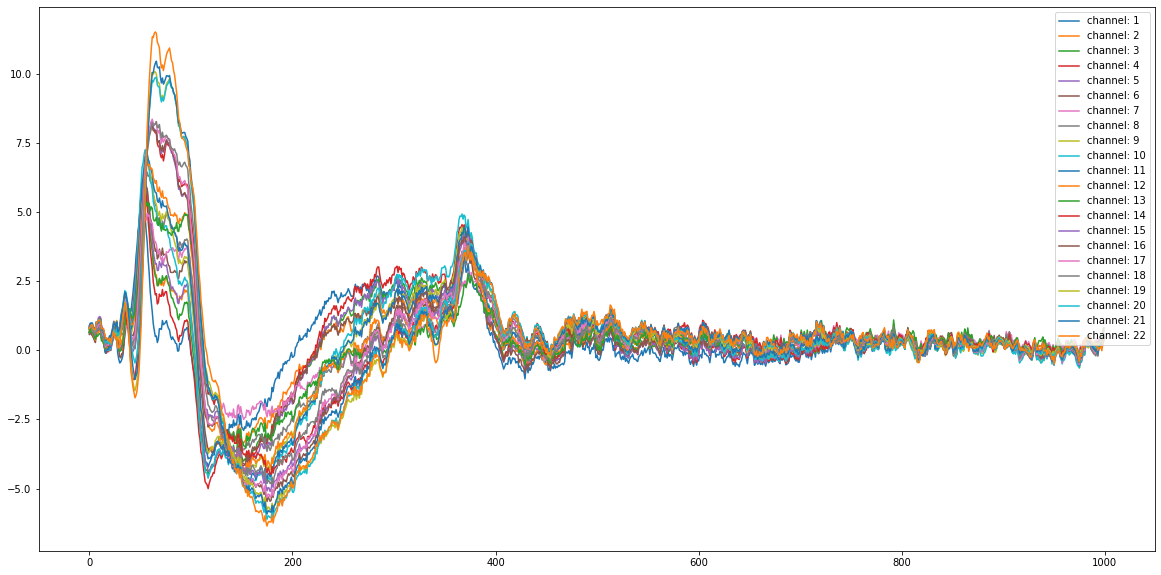

In [ ]:
plot_channel(X_train_valid)

## Augmentation Method 1: Trimming, Maxpooling, Averaging+Noise, and Subsampling

In [ ]:
# TA's method

def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data
    X = X[:,:,0:500]
    
    # Maxpooling the data
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    total_X = X_max
    total_y = y
    
    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
        
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)

(8460, 22, 250)
(8460,)
(1772, 22, 250)
(1772,)


In [ ]:
from keras.utils import to_categorical
y_train_valid = keras.utils.to_categorical(y_train_valid)
y_test = keras.utils.to_categorical(y_test)
y_train_valid_prep = keras.utils.to_categorical(y_train_valid_prep)
y_test_prep = keras.utils.to_categorical(y_test_prep)

print("===========Before Augmentation===========")
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

print("===========After Augmentation===========")
print('Training/Valid data shape: {}'.format(X_train_valid_prep.shape))
print('Test data shape: {}'.format(X_test_prep.shape))
print('Training/Valid target shape: {}'.format(y_train_valid_prep.shape))
print('Test target shape: {}'.format(y_test_prep.shape))

===========Before Augmentation===========
Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115, 4)
Test target shape: (443, 4)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
===========After Augmentation===========
Training/Valid data shape: (8460, 22, 250)
Test data shape: (1772, 22, 250)
Training/Valid target shape: (8460, 4)
Test target shape: (1772, 4)


## Augmentation Method 2: GAN-generated fake data

In [ ]:
fake_X_train_valid = np.load("fake_X_train_valid.npy")
fake_y_train_valid = np.load("fake_y_train_valid.npy")

fake_y_train_valid -= 769
fake_y_train_valid = keras.utils.to_categorical(fake_y_train_valid)

print(fake_X_train_valid.shape)
print(fake_y_train_valid.shape)

(2116, 22, 500)
(2116, 4)


In [ ]:
X_train_valid_gan = np.concatenate((X_train_valid[:, :, :500], fake_X_train_valid), axis=0)
y_train_valid_gan = np.concatenate((y_train_valid, fake_y_train_valid),axis=0)
X_test_gan = X_test[:, :, :500]
y_test_gan = y_test

print("===========Before Augmentation===========")
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

print("===========After Augmentation===========")
print('Training/Valid data shape: {}'.format(X_train_valid_gan.shape))
print('Test data shape: {}'.format(X_test_gan.shape))
print('Training/Valid target shape: {}'.format(y_train_valid_gan.shape))
print('Test target shape: {}'.format(y_test_gan.shape))

===========Before Augmentation===========
Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115, 4)
Test target shape: (443, 4)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
===========After Augmentation===========
Training/Valid data shape: (4231, 22, 500)
Test data shape: (443, 22, 500)
Training/Valid target shape: (4231, 4)
Test target shape: (443, 4)


# Train

In [ ]:
from keras.initializers import lecun_uniform
def train(model_type=None, sub_idx=None, time_period=1000, data=None, num_epoch=20, num_batch=100, plot=True):
    # different period of time
    X_train_ = data['X_train'][:, :, :time_period]
    X_test_ = data['X_test'][:, :, :time_period]
    y_train_ = data['y_train']
    y_test_ = data['y_test']

    # single subject dataset
    if sub_idx is not None:
        X_train_ = X_train_[np.where(person_train_valid == sub_idx)[0]]
        y_train_ = y_train_[np.where(person_train_valid == sub_idx)[0]]
        X_test_ = X_test_[np.where(person_test == sub_idx)[0]]
        y_test_ = y_test_[np.where(person_test == sub_idx)[0]]

    # split into train and validation set
    perm = np.random.permutation(X_train_.shape[0])
    numTrain = int(0.8*X_train_.shape[0])
    Xtrain = X_train_[perm[0:numTrain]]
    ytrain = y_train_[perm[0:numTrain]]
    Xval = X_train_[perm[numTrain: ]]
    yval = y_train_[perm[numTrain: ]]

    lecun = lecun_uniform()
    model = model_type(lecun, time_period)

    history = model.fit(Xtrain, ytrain, epochs=num_epoch, batch_size=num_batch, validation_data=(Xval, yval), shuffle=True, verbose=1)
    train_score = model.evaluate(X_train_, y_train_)
    test_score = model.evaluate(X_test_, y_test_)

    if plot:
      print(model.summary())

      # Plot training & validation accuracy values
      plt.plot(history.history['categorical_accuracy'])
      plt.plot(history.history['val_categorical_accuracy'])
      plt.title('Model accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Validation'], loc='upper left')
      plt.show()

      # Plot training & validation loss values
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('Model loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Validation'], loc='upper left')
      plt.show()

    return train_score[1]*100, test_score[1]*100

# Models

## CNN1

In [ ]:
from keras.metrics import categorical_accuracy
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, Permute, Reshape
from keras.regularizers import L1L2

In [ ]:
def CNN1(kernel_initializer, time_period):
    model = Sequential(name='CNN')
    
    model.add(Reshape((22, time_period, 1), input_shape=(22, time_period)))
    model.add(Conv2D(29, kernel_size=(1, 4)))
    model.add(Conv2D(29, kernel_size=(22, 1)))
    model.add(BatchNormalization(axis=-1))
    model.add(ELU())
    model.add(MaxPool2D(1,2))
    model.add(Dropout(0.5))

    model.add(Conv2D(49, kernel_size=(1, 6)))
    model.add(BatchNormalization(axis=-1))
    model.add(ELU())
    model.add(MaxPool2D(1,2))
    model.add(Dropout(0.5))

    model.add(Conv2D(104, kernel_size=(1, 5)))
    model.add(BatchNormalization(axis=-1))
    model.add(ELU())
    model.add(MaxPool2D(1,2))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

    return model

## CNN_ResNet

In [ ]:
from keras.metrics import categorical_accuracy
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, Permute, Reshape
from keras.layers import AveragePooling1D, Add, Input
from keras.regularizers import L1, L2, L1L2

In [ ]:
def cnnres(kernel_initializer, time_period):
    inputs = Input(shape=(22, time_period))

    r1 = Reshape((22, time_period, 1), input_shape=(22, time_period))(inputs)
    p1 = Permute((2, 3, 1))(r1)
    c1 = Conv2D(200, (10, 1), activation='elu', padding='same')(p1)
    mp1 = MaxPool2D((2, 1), padding='same')(c1)
    b1 = BatchNormalization(momentum=0.9, epsilon=1e-05)(mp1)
    dp = Dropout(0.5)(b1)

    for _ in range(3):

        c2 = Conv2D(200, (15, 1), padding='same')(dp)
        b2 = BatchNormalization(momentum=0.9, epsilon=1e-05)(c2)

        c3 = Conv2D(200, (15, 1), activation='elu', padding='same')(b2)
        b3 = BatchNormalization(momentum=0.9, epsilon=1e-05)(c3)

        con = Add()([dp, b3])

        mp = MaxPool2D((2, 1), padding='same')(con)
        dp = Dropout(0.5)(mp)

    r1 = Reshape((4, -1))(dp)
    f1 = Flatten()(r1)

    outputs = Dense(4, activation='softmax', kernel_regularizer=L1(0.01), activity_regularizer=L2(0.01))(f1)
    model = keras.models.Model(inputs=inputs, outputs=outputs, name='ResNet')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

    return model

## CNN_GRU

In [ ]:
from keras.layers import GRU

def CNN_GRU(kernel_initializer, time_period):
    model = Sequential(name='CNN_GRU')

    model.add(Reshape((22, time_period, 1), input_shape=(22, time_period)))
    model.add(Conv2D(29, kernel_size=(1, 4)))
    model.add(Conv2D(29, kernel_size=(22, 1)))
    model.add(BatchNormalization(axis=-1))
    model.add(ELU())
    model.add(MaxPool2D(1,2))
    model.add(Dropout(0.5))

    model.add(Conv2D(49, kernel_size=(1, 6)))
    model.add(BatchNormalization(axis=-1))
    model.add(ELU())
    model.add(MaxPool2D(1,2))
    model.add(Dropout(0.5))

    model.add(Conv2D(104, kernel_size=(1, 5)))
    model.add(BatchNormalization(axis=-1))
    model.add(ELU())
    model.add(MaxPool2D(1,2))
    model.add(Dropout(0.5))

    # FC+GRU layer
    model.add(Flatten())
    model.add(Dense((50)))
    model.add(Reshape((50,1)))
    model.add(GRU(10, dropout=0.5, recurrent_dropout=0.5, input_shape=(50,1), return_sequences=False))
    
    # FClayer
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

    return model

## CNN_LSTM

In [ ]:
from keras.layers import LSTM

def CNN_LSTM(kernel_initializer, time_period):
    model = Sequential(name='CNN_LSTM')

    model.add(Reshape((22, time_period, 1), input_shape=(22, time_period)))
    model.add(Conv2D(29, kernel_size=(1, 4)))
    model.add(Conv2D(29, kernel_size=(22, 1)))
    model.add(BatchNormalization(axis=-1))
    model.add(ELU())
    model.add(MaxPool2D(1,2))
    model.add(Dropout(0.5))

    model.add(Conv2D(49, kernel_size=(1, 6)))
    model.add(BatchNormalization(axis=-1))
    model.add(ELU())
    model.add(MaxPool2D(1,2))
    model.add(Dropout(0.5))

    model.add(Conv2D(104, kernel_size=(1, 5)))
    model.add(BatchNormalization(axis=-1))
    model.add(ELU())
    model.add(MaxPool2D(1,2))
    model.add(Dropout(0.5))

    # FC+GRU layer
    model.add(Flatten())
    model.add(Dense((50)))
    model.add(Reshape((50,1)))
    model.add(LSTM(20, dropout=0.5, recurrent_dropout=0.5, input_shape=(50,1), return_sequences=False))
    
    # FClayer
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

    return model

# Experiments

## Optimize over different subject

We use CNN1 here because it is our best model in our pre-experiment. We can see that our CNN acheive best test performance when training only on subject 4 or all subjects. To avoid overfitting, we will use all subjects's data in the later training. 

Running Subject 1
Epoch 1/50
2/2 [==============================] - 1s 257ms/step - loss: 2.3381 - categorical_accuracy: 0.2113 - val_loss: 1.9470 - val_categorical_accuracy: 0.3333
Epoch 2/50
2/2 [==============================] - 0s 89ms/step - loss: 1.8954 - categorical_accuracy: 0.2987 - val_loss: 2.5040 - val_categorical_accuracy: 0.2500
Epoch 3/50
2/2 [==============================] - 0s 81ms/step - loss: 1.5242 - categorical_accuracy: 0.3946 - val_loss: 3.0022 - val_categorical_accuracy: 0.2292
Epoch 4/50
2/2 [==============================] - 0s 76ms/step - loss: 1.5560 - categorical_accuracy: 0.4079 - val_loss: 3.1885 - val_categorical_accuracy: 0.2292
Epoch 5/50
2/2 [==============================] - 0s 71ms/step - loss: 1.2863 - categorical_accuracy: 0.5018 - val_loss: 3.2137 - val_categorical_accuracy: 0.2917
Epoch 6/50
2/2 [==============================] - 0s 71ms/step - loss: 1.0379 - categorical_accuracy: 0.5606 - val_loss: 3.3055 - val_categorical_accuracy: 0.2917
Epo

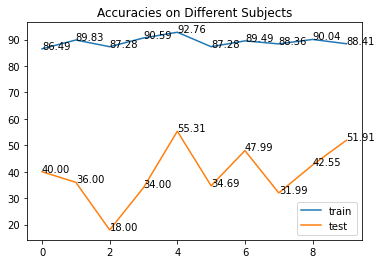

In [ ]:
train_scores = []
test_scores = []
subjects = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

data = {
    'X_train': X_train_valid,
    'X_test': X_test,
    'y_train': y_train_valid,
    'y_test': y_test
}

for sub in subjects:
  if sub == 9: 
    sub = None
    print("Running All Subjects")
  else:
    print("Running Subject %d" %(sub+1))
  train_acc, test_acc = train(CNN1, sub_idx=sub, data=data, num_epoch=50, plot=False)
  train_scores.append(train_acc)
  test_scores.append(test_acc)

plt.plot(subjects, train_scores, label='train')
plt.plot(subjects, test_scores, label='test')
plt.legend()
plt.title("Accuracies on Different Subjects")
for a, b, c in zip(subjects, train_scores, test_scores): 
    plt.text(a, b, str(b)[:5])
    plt.text(a, c, str(c)[:5])

## Optimize as a function of time

We use CNN1 here because it is our best model in our pre-experiment. We can see that t = 400, 500, and 600 are three best time period for training a model. This solidates our trimming operation of the first 500 timestep in the data processing part above. 

Time Period = 200
Epoch 1/50
17/17 [==============================] - 3s 81ms/step - loss: 2.0367 - categorical_accuracy: 0.2535 - val_loss: 1.8518 - val_categorical_accuracy: 0.3144
Epoch 2/50
17/17 [==============================] - 0s 11ms/step - loss: 1.8380 - categorical_accuracy: 0.3034 - val_loss: 1.5661 - val_categorical_accuracy: 0.3404
Epoch 3/50
17/17 [==============================] - 0s 11ms/step - loss: 1.7242 - categorical_accuracy: 0.3298 - val_loss: 1.5299 - val_categorical_accuracy: 0.3428
Epoch 4/50
17/17 [==============================] - 0s 11ms/step - loss: 1.6491 - categorical_accuracy: 0.3670 - val_loss: 1.4175 - val_categorical_accuracy: 0.3948
Epoch 5/50
17/17 [==============================] - 0s 11ms/step - loss: 1.5261 - categorical_accuracy: 0.3758 - val_loss: 1.4979 - val_categorical_accuracy: 0.3712
Epoch 6/50
17/17 [==============================] - 0s 11ms/step - loss: 1.5133 - categorical_accuracy: 0.3844 - val_loss: 1.4425 - val_categorical_accuracy:

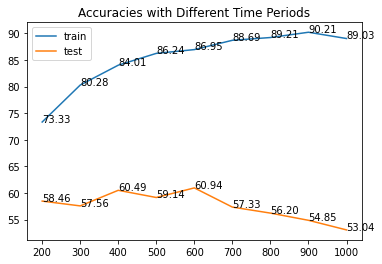

In [ ]:
train_scores = []
test_scores = []
times = [200, 300, 400, 500, 600, 700, 800, 900, 1000]

data = {
    'X_train': X_train_valid,
    'X_test': X_test,
    'y_train': y_train_valid,
    'y_test': y_test
}

for t in times:
  print("Time Period = %d" %(t))
  train_acc, test_acc = train(CNN1, time_period=t, data=data, num_epoch=50, plot=False)
  train_scores.append(train_acc)
  test_scores.append(test_acc)

plt.plot(times, train_scores, label='train')
plt.plot(times, test_scores, label='test')
plt.legend()
plt.title("Accuracies with Different Time Periods")
for a, b, c in zip(times, train_scores, test_scores): 
    plt.text(a, b, str(b)[:5])
    plt.text(a, c, str(c)[:5])

## Compare Data Processing Technique

We use CNN1 here because it is our best model in our pre-experiment. We can see that Augmentation Method 1 is best suited data set for training a neural network. 

Epoch 1/200
17/17 [==============================] - 34s 84ms/step - loss: 2.1804 - categorical_accuracy: 0.2233 - val_loss: 2.0114 - val_categorical_accuracy: 0.3333
Epoch 2/200
17/17 [==============================] - 1s 36ms/step - loss: 1.8564 - categorical_accuracy: 0.3343 - val_loss: 2.2286 - val_categorical_accuracy: 0.3593
Epoch 3/200
17/17 [==============================] - 1s 36ms/step - loss: 1.6976 - categorical_accuracy: 0.3900 - val_loss: 1.7543 - val_categorical_accuracy: 0.3783
Epoch 4/200
17/17 [==============================] - 1s 36ms/step - loss: 1.5603 - categorical_accuracy: 0.4335 - val_loss: 1.5958 - val_categorical_accuracy: 0.4043
Epoch 5/200
17/17 [==============================] - 1s 36ms/step - loss: 1.4376 - categorical_accuracy: 0.4787 - val_loss: 1.7160 - val_categorical_accuracy: 0.3924
Epoch 6/200
17/17 [==============================] - 1s 36ms/step - loss: 1.2638 - categorical_accuracy: 0.5282 - val_loss: 1.5393 - val_categorical_accuracy: 0.4161
Epo

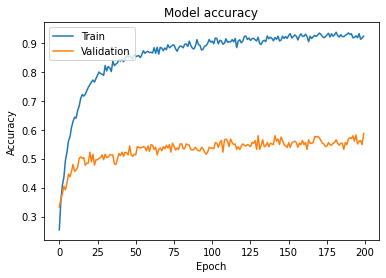

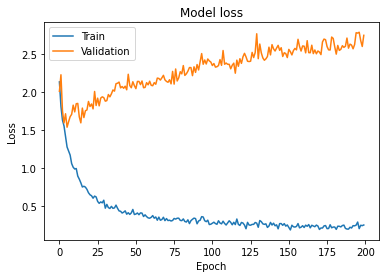

Training Accuracy: 91.67848825454712
Test Accuracy: 57.562077045440674


In [ ]:
# Original Data
data = {
    'X_train': X_train_valid,
    'X_test': X_test,
    'y_train': y_train_valid,
    'y_test': y_test
}
train_acc, test_acc = train(CNN1, data=data, time_period=1000, num_epoch=200, num_batch=100)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

Epoch 1/200
68/68 [==============================] - 4s 29ms/step - loss: 1.9424 - categorical_accuracy: 0.2865 - val_loss: 1.3645 - val_categorical_accuracy: 0.4031
Epoch 2/200
68/68 [==============================] - 1s 11ms/step - loss: 1.5497 - categorical_accuracy: 0.3790 - val_loss: 1.1463 - val_categorical_accuracy: 0.5077
Epoch 3/200
68/68 [==============================] - 1s 11ms/step - loss: 1.2949 - categorical_accuracy: 0.4857 - val_loss: 1.0186 - val_categorical_accuracy: 0.5810
Epoch 4/200
68/68 [==============================] - 1s 11ms/step - loss: 1.1392 - categorical_accuracy: 0.5407 - val_loss: 0.9250 - val_categorical_accuracy: 0.6241
Epoch 5/200
68/68 [==============================] - 1s 11ms/step - loss: 1.0694 - categorical_accuracy: 0.5549 - val_loss: 0.8243 - val_categorical_accuracy: 0.6726
Epoch 6/200
68/68 [==============================] - 1s 11ms/step - loss: 1.0023 - categorical_accuracy: 0.5960 - val_loss: 0.7915 - val_categorical_accuracy: 0.6874
Epoc

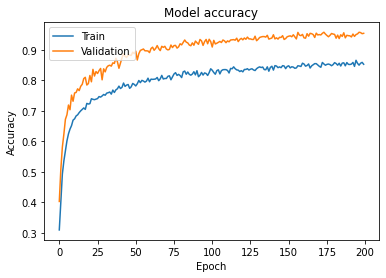

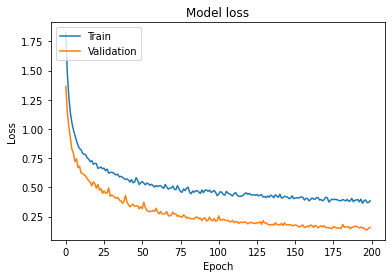

Training Accuracy: 98.06146621704102
Test Accuracy: 71.16252779960632


In [ ]:
# Augmentation Method 1
data = {
    'X_train': X_train_valid_prep,
    'X_test': X_test_prep,
    'y_train': y_train_valid_prep,
    'y_test': y_test_prep
}
train_acc, test_acc = train(CNN1, data=data, time_period=250, num_epoch=200, num_batch=100)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

Epoch 1/200
34/34 [==============================] - 4s 65ms/step - loss: 2.1197 - categorical_accuracy: 0.2417 - val_loss: 1.5652 - val_categorical_accuracy: 0.3365
Epoch 2/200
34/34 [==============================] - 1s 19ms/step - loss: 1.9231 - categorical_accuracy: 0.3029 - val_loss: 1.4504 - val_categorical_accuracy: 0.3270
Epoch 3/200
34/34 [==============================] - 1s 19ms/step - loss: 1.8105 - categorical_accuracy: 0.3179 - val_loss: 1.6310 - val_categorical_accuracy: 0.3329
Epoch 4/200
34/34 [==============================] - 1s 19ms/step - loss: 1.7017 - categorical_accuracy: 0.3319 - val_loss: 1.5056 - val_categorical_accuracy: 0.3636
Epoch 5/200
34/34 [==============================] - 1s 19ms/step - loss: 1.6385 - categorical_accuracy: 0.3565 - val_loss: 1.4049 - val_categorical_accuracy: 0.3613
Epoch 6/200
34/34 [==============================] - 1s 19ms/step - loss: 1.5744 - categorical_accuracy: 0.3730 - val_loss: 1.3764 - val_categorical_accuracy: 0.3471
Epoc

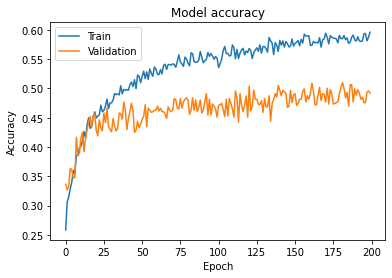

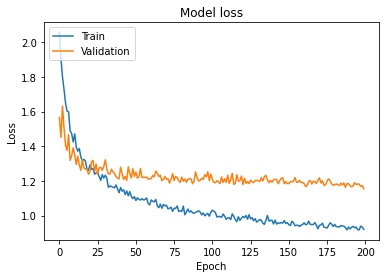

Training Accuracy: 64.40557837486267
Test Accuracy: 58.465009927749634


In [ ]:
# Augmentation Method 2
data = {
    'X_train': X_train_valid_gan,
    'X_test': X_test_gan,
    'y_train': y_train_valid_gan,
    'y_test': y_test_gan
}
train_acc, test_acc = train(CNN1, data=data, time_period=500, num_epoch=200, num_batch=100)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

## Compare Model Performance

CNN1 is our best design.

### CNN1

Epoch 1/200
68/68 [==============================] - 2s 15ms/step - loss: 1.9248 - categorical_accuracy: 0.2896 - val_loss: 1.4028 - val_categorical_accuracy: 0.4173
Epoch 2/200
68/68 [==============================] - 1s 11ms/step - loss: 1.4936 - categorical_accuracy: 0.3943 - val_loss: 1.2207 - val_categorical_accuracy: 0.4882
Epoch 3/200
68/68 [==============================] - 1s 11ms/step - loss: 1.2773 - categorical_accuracy: 0.4735 - val_loss: 1.1557 - val_categorical_accuracy: 0.5349
Epoch 4/200
68/68 [==============================] - 1s 11ms/step - loss: 1.1613 - categorical_accuracy: 0.5309 - val_loss: 0.9498 - val_categorical_accuracy: 0.6129
Epoch 5/200
68/68 [==============================] - 1s 11ms/step - loss: 1.0651 - categorical_accuracy: 0.5622 - val_loss: 0.8878 - val_categorical_accuracy: 0.6560
Epoch 6/200
68/68 [==============================] - 1s 11ms/step - loss: 1.0226 - categorical_accuracy: 0.5987 - val_loss: 0.8087 - val_categorical_accuracy: 0.6980
Epoc

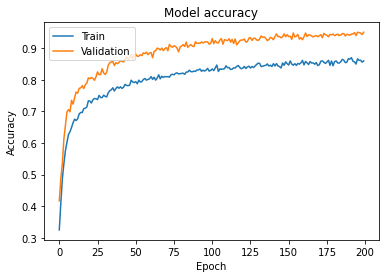

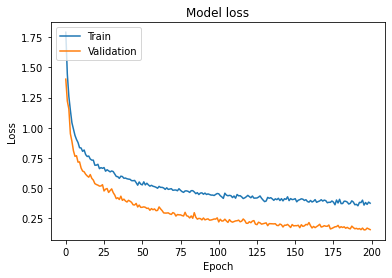

Training Accuracy: 98.06146621704102
Test Accuracy: 72.12189435958862


In [ ]:
data = {
    'X_train': X_train_valid_prep,
    'X_test': X_test_prep,
    'y_train': y_train_valid_prep,
    'y_test': y_test_prep
}

train_acc, test_acc = train(CNN1, data=data, time_period=250, num_epoch=200, num_batch=100)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

### CNN_ResNet

Epoch 1/200
68/68 [==============================] - 10s 83ms/step - loss: 14.4393 - categorical_accuracy: 0.3086 - val_loss: 4.1841 - val_categorical_accuracy: 0.4610
Epoch 2/200
68/68 [==============================] - 5s 66ms/step - loss: 8.6127 - categorical_accuracy: 0.3800 - val_loss: 3.7202 - val_categorical_accuracy: 0.4905
Epoch 3/200
68/68 [==============================] - 5s 68ms/step - loss: 6.3892 - categorical_accuracy: 0.4492 - val_loss: 3.5041 - val_categorical_accuracy: 0.4805
Epoch 4/200
68/68 [==============================] - 5s 68ms/step - loss: 5.0946 - categorical_accuracy: 0.4751 - val_loss: 2.4310 - val_categorical_accuracy: 0.6283
Epoch 5/200
68/68 [==============================] - 5s 68ms/step - loss: 3.8978 - categorical_accuracy: 0.5010 - val_loss: 2.1842 - val_categorical_accuracy: 0.6111
Epoch 6/200
68/68 [==============================] - 5s 68ms/step - loss: 3.2412 - categorical_accuracy: 0.5171 - val_loss: 2.0792 - val_categorical_accuracy: 0.6259
Ep

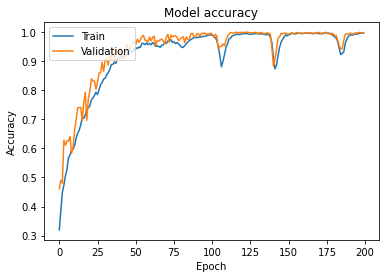

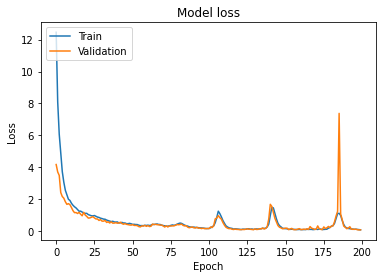

Training Accuracy: 99.81087446212769
Test Accuracy: 69.24379467964172


In [ ]:
data = {
    'X_train': X_train_valid_prep,
    'X_test': X_test_prep,
    'y_train': y_train_valid_prep,
    'y_test': y_test_prep
}

train_acc, test_acc = train(cnnres, data=data, time_period=250, num_epoch=200, num_batch=100)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

### CNN_GRU

Epoch 1/200
68/68 [==============================] - 48s 196ms/step - loss: 1.4017 - categorical_accuracy: 0.2607 - val_loss: 1.3694 - val_categorical_accuracy: 0.3085
Epoch 2/200
68/68 [==============================] - 12s 172ms/step - loss: 1.3742 - categorical_accuracy: 0.2910 - val_loss: 1.3183 - val_categorical_accuracy: 0.3859
Epoch 3/200
68/68 [==============================] - 12s 176ms/step - loss: 1.3433 - categorical_accuracy: 0.3474 - val_loss: 1.2570 - val_categorical_accuracy: 0.4173
Epoch 4/200
68/68 [==============================] - 12s 171ms/step - loss: 1.2811 - categorical_accuracy: 0.3794 - val_loss: 1.2219 - val_categorical_accuracy: 0.4285
Epoch 5/200
68/68 [==============================] - 12s 179ms/step - loss: 1.2268 - categorical_accuracy: 0.4304 - val_loss: 1.1351 - val_categorical_accuracy: 0.4793
Epoch 6/200
68/68 [==============================] - 12s 175ms/step - loss: 1.1681 - categorical_accuracy: 0.4644 - val_loss: 1.1053 - val_categorical_accuracy:

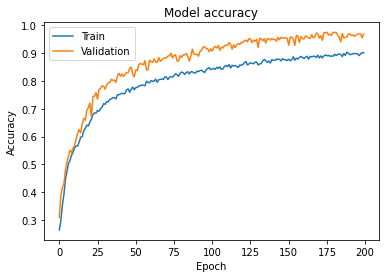

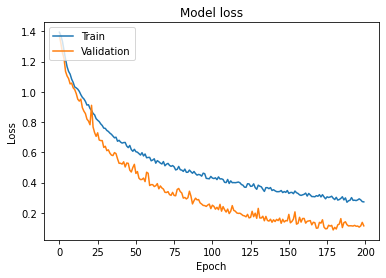

Training Accuracy: 98.65248203277588
Test Accuracy: 63.71331810951233


In [ ]:
data = {
    'X_train': X_train_valid_prep,
    'X_test': X_test_prep,
    'y_train': y_train_valid_prep,
    'y_test': y_test_prep
}

train_acc, test_acc = train(CNN_GRU, data=data, time_period=250, num_epoch=200, num_batch=100)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

### CNN_LSTM

Epoch 1/200
68/68 [==============================] - 16s 201ms/step - loss: 1.3811 - categorical_accuracy: 0.2767 - val_loss: 1.3205 - val_categorical_accuracy: 0.3617
Epoch 2/200
68/68 [==============================] - 13s 196ms/step - loss: 1.2864 - categorical_accuracy: 0.4005 - val_loss: 1.2353 - val_categorical_accuracy: 0.4439
Epoch 3/200
68/68 [==============================] - 13s 193ms/step - loss: 1.1947 - categorical_accuracy: 0.4566 - val_loss: 1.1088 - val_categorical_accuracy: 0.5136
Epoch 4/200
68/68 [==============================] - 13s 190ms/step - loss: 1.1484 - categorical_accuracy: 0.4876 - val_loss: 1.0568 - val_categorical_accuracy: 0.5372
Epoch 5/200
68/68 [==============================] - 13s 187ms/step - loss: 1.0930 - categorical_accuracy: 0.5119 - val_loss: 1.0093 - val_categorical_accuracy: 0.5632
Epoch 6/200
68/68 [==============================] - 13s 194ms/step - loss: 1.0717 - categorical_accuracy: 0.5368 - val_loss: 1.0030 - val_categorical_accuracy:

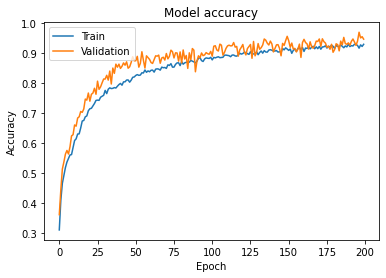

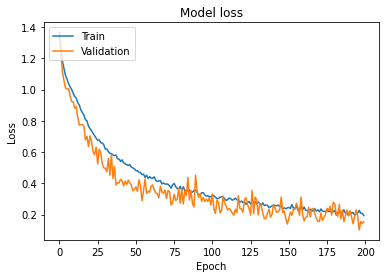

Training Accuracy: 96.82033061981201
Test Accuracy: 64.33408856391907


In [ ]:
data = {
    'X_train': X_train_valid_prep,
    'X_test': X_test_prep,
    'y_train': y_train_valid_prep,
    'y_test': y_test_prep
}

train_acc, test_acc = train(CNN_LSTM, data=data, time_period=250, num_epoch=200, num_batch=100)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)